In [1]:
import pandas as pd
import numpy as np
import joblib
import re, math
from urllib.parse import urlparse, parse_qs
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# ===============================
# 1️⃣ Load dataset
# ===============================
df = pd.read_csv(r"D:\QRusaderTrainedModel\src\merged_url_datasets.csv")
df.rename(columns={"Label":"label"}, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     8000 non-null   object
 1   label   8000 non-null   object
dtypes: object(2)
memory usage: 125.1+ KB


In [4]:
df.head(30)

,URL,label
0,obit-obits.com/d20091114zp21,safe
1,myspace.com/denigauthier,safe
2,skateboardpark.com/skateboardpark/viewpark.asp...,safe
3,http://algiba.com/index.php?option=com_content...,malicious
4,https://mitsui-jyuku.mixh.jp/uploads/464ODNO38...,malicious
5,powermoves.capitaliq.com/index.php/2011/08/17/...,safe
6,www.australianwebservices.com/attachments/payp...,safe
7,hockeyleaguehistory.com/Stanley_Cup.htm,safe
8,https://mitsui-jyuku.mixh.jp/uploads/862ODNO38...,malicious
9,http://kizombafestival.pl/index.php?option=com...,malicious


In [5]:
count = df.label.value_counts()
count

label
safe         4000
malicious    4000
Name: count, dtype: int64

In [6]:
df['url'] = df['URL'].replace('www.', '', regex=True)
df

,URL,label,url
0,obit-obits.com/d20091114zp21,safe,obit-obits.com/d20091114zp21
1,myspace.com/denigauthier,safe,myspace.com/denigauthier
2,skateboardpark.com/skateboardpark/viewpark.asp...,safe,skateboardpark.com/skateboardpark/viewpark.asp...
3,http://algiba.com/index.php?option=com_content...,malicious,http://algiba.com/index.php?option=com_content...
4,https://mitsui-jyuku.mixh.jp/uploads/464ODNO38...,malicious,https://mitsui-jyuku.mixh.jp/uploads/464ODNO38...
...,...,...,...
7995,www.gamespot.com/dreamcast/action/spawn/,malicious,gamespot.com/dreamcast/action/spawn/
7996,http://anaximhost.com/clients/status/docsdrive/,malicious,http://anaximhost.com/clients/status/docsdrive/
7997,mylife.com/fbwdrew,safe,mylife.com/fbwdrew
7998,http://9779.info/%E5%B0%91%E5%84%BF%E7%A7%8D%E...,malicious,http://9779.info/%E5%B0%91%E5%84%BF%E7%A7%8D%E...


In [7]:
# ===============================
# Step 3+: Enhanced Feature Extraction
# ===============================

import re, math
from urllib.parse import urlparse
from datetime import datetime
import shelve, whois

# -------------------------------
# WHOIS caching (keep for domain age)
# -------------------------------
CACHE_FILE = "whois_cache.db"

def get_whois_safe(domain):
    with shelve.open(CACHE_FILE) as cache:
        if domain in cache:
            return cache[domain].get("has_whois", 0), cache[domain].get("domain_age_days", None)
        try:
            w = whois.whois(domain)
            if not hasattr(w, "creation_date"):
                has_dns, age_days = 0, None
            else:
                has_dns = 1
                creation_date = w.creation_date
                if isinstance(creation_date, list):
                    creation_date = creation_date[0]
                age_days = (datetime.now() - creation_date).days if creation_date else None
        except Exception:
            has_dns, age_days = 0, None
        cache[domain] = {"has_whois": has_dns, "domain_age_days": age_days}
        return has_dns, age_days

# -------------------------------
# Helper Functions
# -------------------------------
def has_ip(url):
    return 1 if re.match(r"http[s]?://\d+\.\d+\.\d+\.\d+", url) else 0

def is_shortened(url):
    shortening_services = ["bit.ly","tinyurl","goo.gl","t.co","ow.ly","shorte.st","cutt.ly"]
    return 1 if any(s in url for s in shortening_services) else 0

def shannon_entropy(data):
    if not data:
        return 0
    prob = [float(data.count(c))/len(data) for c in set(data)]
    return -sum(p*math.log2(p) for p in prob)

suspicious_keywords = ["secure","account","login","update","free","bonus",
                       "ebayisapi","banking","confirm","signin","verification"]

def contains_suspicious_word(url):
    return sum(word in url.lower() for word in suspicious_keywords)

def has_suspicious_ext(url):
    suspicious_ext = [
    ".exe", ".bat", ".cmd", ".msi", ".scr",
    ".js", ".vbs", ".wsf", ".ps1", ".jar", ".hta",
    ".docm", ".xlsm", ".pptm", ".zip", ".rar", ".7z",
    ".tar", ".gz", ".apk", ".pif", ".lnk", ".iso", ".img"
    ]
    return 1 if any(url.lower().endswith(ext) for ext in suspicious_ext) else 0

# -------------------------------
# Enhanced Feature Extraction
# -------------------------------
def extract_features(url):
    parsed = urlparse(url if url.startswith("http") else "http://" + url)
    domain = parsed.netloc or parsed.path
    path = parsed.path
    query = parsed.query
    
    # WHOIS / domain features
    has_dns, domain_age_days = get_whois_safe(domain)
    domain_age_bin = 0
    if domain_age_days is not None:
        if domain_age_days < 30:
            domain_age_bin = 1
        elif domain_age_days < 365:
            domain_age_bin = 2
        else:
            domain_age_bin = 3

    # URL structural features
    special_chars = ['@','?','-','=','.','!','#','$','&','~','*','%','+','^','_']
    total_special_char = sum(url.count(c) for c in special_chars)
    special_char_ratio = total_special_char / max(1, len(url))
    
    subdomain_count = max(domain.count(".") - 1, 0)
    path_depth = path.count('/')
    query_param_amp_count = query.count('&') + (1 if query else 0)
    
    tld = domain.split('.')[-1]
    tld_length = len(tld)
    numeric_tld = 1 if any(c.isdigit() for c in tld) else 0
    subdomain_ratio = subdomain_count / max(1, len(domain))
    digit_letter_ratio = sum(c.isdigit() for c in url) / max(1, sum(c.isalpha() for c in url))
    
    # -------------------------------
    # Advanced URL features
    # -------------------------------
    url_upper_ratio = sum(1 for c in url if c.isupper()) / max(1, len(url))
    url_encoded_ratio = url.count('%') / max(1, len(url))
    repeated_char_count = sum(url.count(c*2) for c in set(url))
    path_token_count = len([t for t in path.split('/') if t])
    query_token_count = len([q for q in query.split('&') if q])
    suspicious_word_count = contains_suspicious_word(url)

    return {
        "url": url,
        "domain": domain,
        "url_length": len(url),
        "Shortining_Service": is_shortened(url),
        "having_ip_address": has_ip(url),
        "subdomain_count": subdomain_count,
        "subdomain_ratio": subdomain_ratio,
        "path_depth": path_depth,
        "path_length": len(path),
        "query_length": len(query),
        "param_count": query.count("="),
        "query_param_amp_count": query_param_amp_count,
        "digit_letter_ratio": digit_letter_ratio,
        "entropy": shannon_entropy(url),
        "total_special_char": total_special_char,
        "special_char_ratio": special_char_ratio,
        "risky_tld": 1 if tld in ["zip","xyz","top","club","info"] else 0,
        "tld_length": tld_length,
        "numeric_tld": numeric_tld,
        "has_suspicious_ext": has_suspicious_ext(url),
        "suspicious_word_count": suspicious_word_count,
        "url_upper_ratio": url_upper_ratio,
        "url_encoded_ratio": url_encoded_ratio,
        "repeated_char_count": repeated_char_count,
        "path_token_count": path_token_count,
        "query_token_count": query_token_count,
        "has_whois": has_dns,
        "domain_age_days": domain_age_days,
        "domain_age_bin": domain_age_bin
    }


In [8]:
print(df.columns)

Index(['URL', 'label', 'url'], dtype='object')


In [9]:
# ===============================
# 4 Parallel Feature Extraction (Enhanced)
# ===============================

from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from pathlib import Path
import csv

# Load merged CSV
df = pd.read_csv(r"D:\QRusaderTrainedModel\src\merged_url_datasets.csv")
df.rename(columns={"Label": "label"}, inplace=True)

# Safe wrapper for feature extraction
def safe_extract(url):
    try:
        return extract_features(url)
    except Exception as e:
        print(f"⚠️ Error processing URL {url}: {e}")
        return None

# Define output file path and ensure directory exists
output_file = Path(r"D:\QRusaderTrainedModel\src\url_features_enhanced.csv")
output_file.parent.mkdir(parents=True, exist_ok=True)

# Initialize list for extracted features
features = []

# -------------------------------
# Parallel processing
# -------------------------------
with ThreadPoolExecutor(max_workers=20) as executor:
    future_to_url = {executor.submit(safe_extract, url): url for url in df["URL"]}
    
    for i, future in enumerate(as_completed(future_to_url), 1):
        result = future.result()
        if result is not None:
            features.append(result)
        if i % 100 == 0 or i == len(df):
            print(f"Processed {i}/{len(df)} URLs")

# -------------------------------
# Convert to DataFrame
# -------------------------------
features_df = pd.DataFrame(features)
print(f"✅ Feature extraction completed. Shape: {features_df.shape}")
print(features_df.head())

# -------------------------------
# Merge labels from original dataset
# -------------------------------
features_df = features_df.merge(df[['URL','label']], left_on='url', right_on='URL', how='left')
features_df.drop(columns=['URL'], inplace=True)

# -------------------------------
# Save to CSV safely
# -------------------------------
features_df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Features with labels saved at: {output_file}")


Processed 100/8000 URLs
Processed 200/8000 URLs
Processed 300/8000 URLs
Processed 400/8000 URLs
Processed 500/8000 URLs
Processed 600/8000 URLs
Processed 700/8000 URLs
Processed 800/8000 URLs
Processed 900/8000 URLs
Processed 1000/8000 URLs
Processed 1100/8000 URLs
Processed 1200/8000 URLs
Processed 1300/8000 URLs
Processed 1400/8000 URLs
Processed 1500/8000 URLs
Processed 1600/8000 URLs
Processed 1700/8000 URLs
Processed 1800/8000 URLs
Processed 1900/8000 URLs
Processed 2000/8000 URLs
Processed 2100/8000 URLs
Processed 2200/8000 URLs
Processed 2300/8000 URLs
Processed 2400/8000 URLs
Processed 2500/8000 URLs
Processed 2600/8000 URLs
Processed 2700/8000 URLs
Processed 2800/8000 URLs
Processed 2900/8000 URLs
Processed 3000/8000 URLs
Processed 3100/8000 URLs
Processed 3200/8000 URLs
Processed 3300/8000 URLs
Processed 3400/8000 URLs
Processed 3500/8000 URLs
Processed 3600/8000 URLs
Processed 3700/8000 URLs
Processed 3800/8000 URLs
Processed 3900/8000 URLs
Processed 4000/8000 URLs
Processed

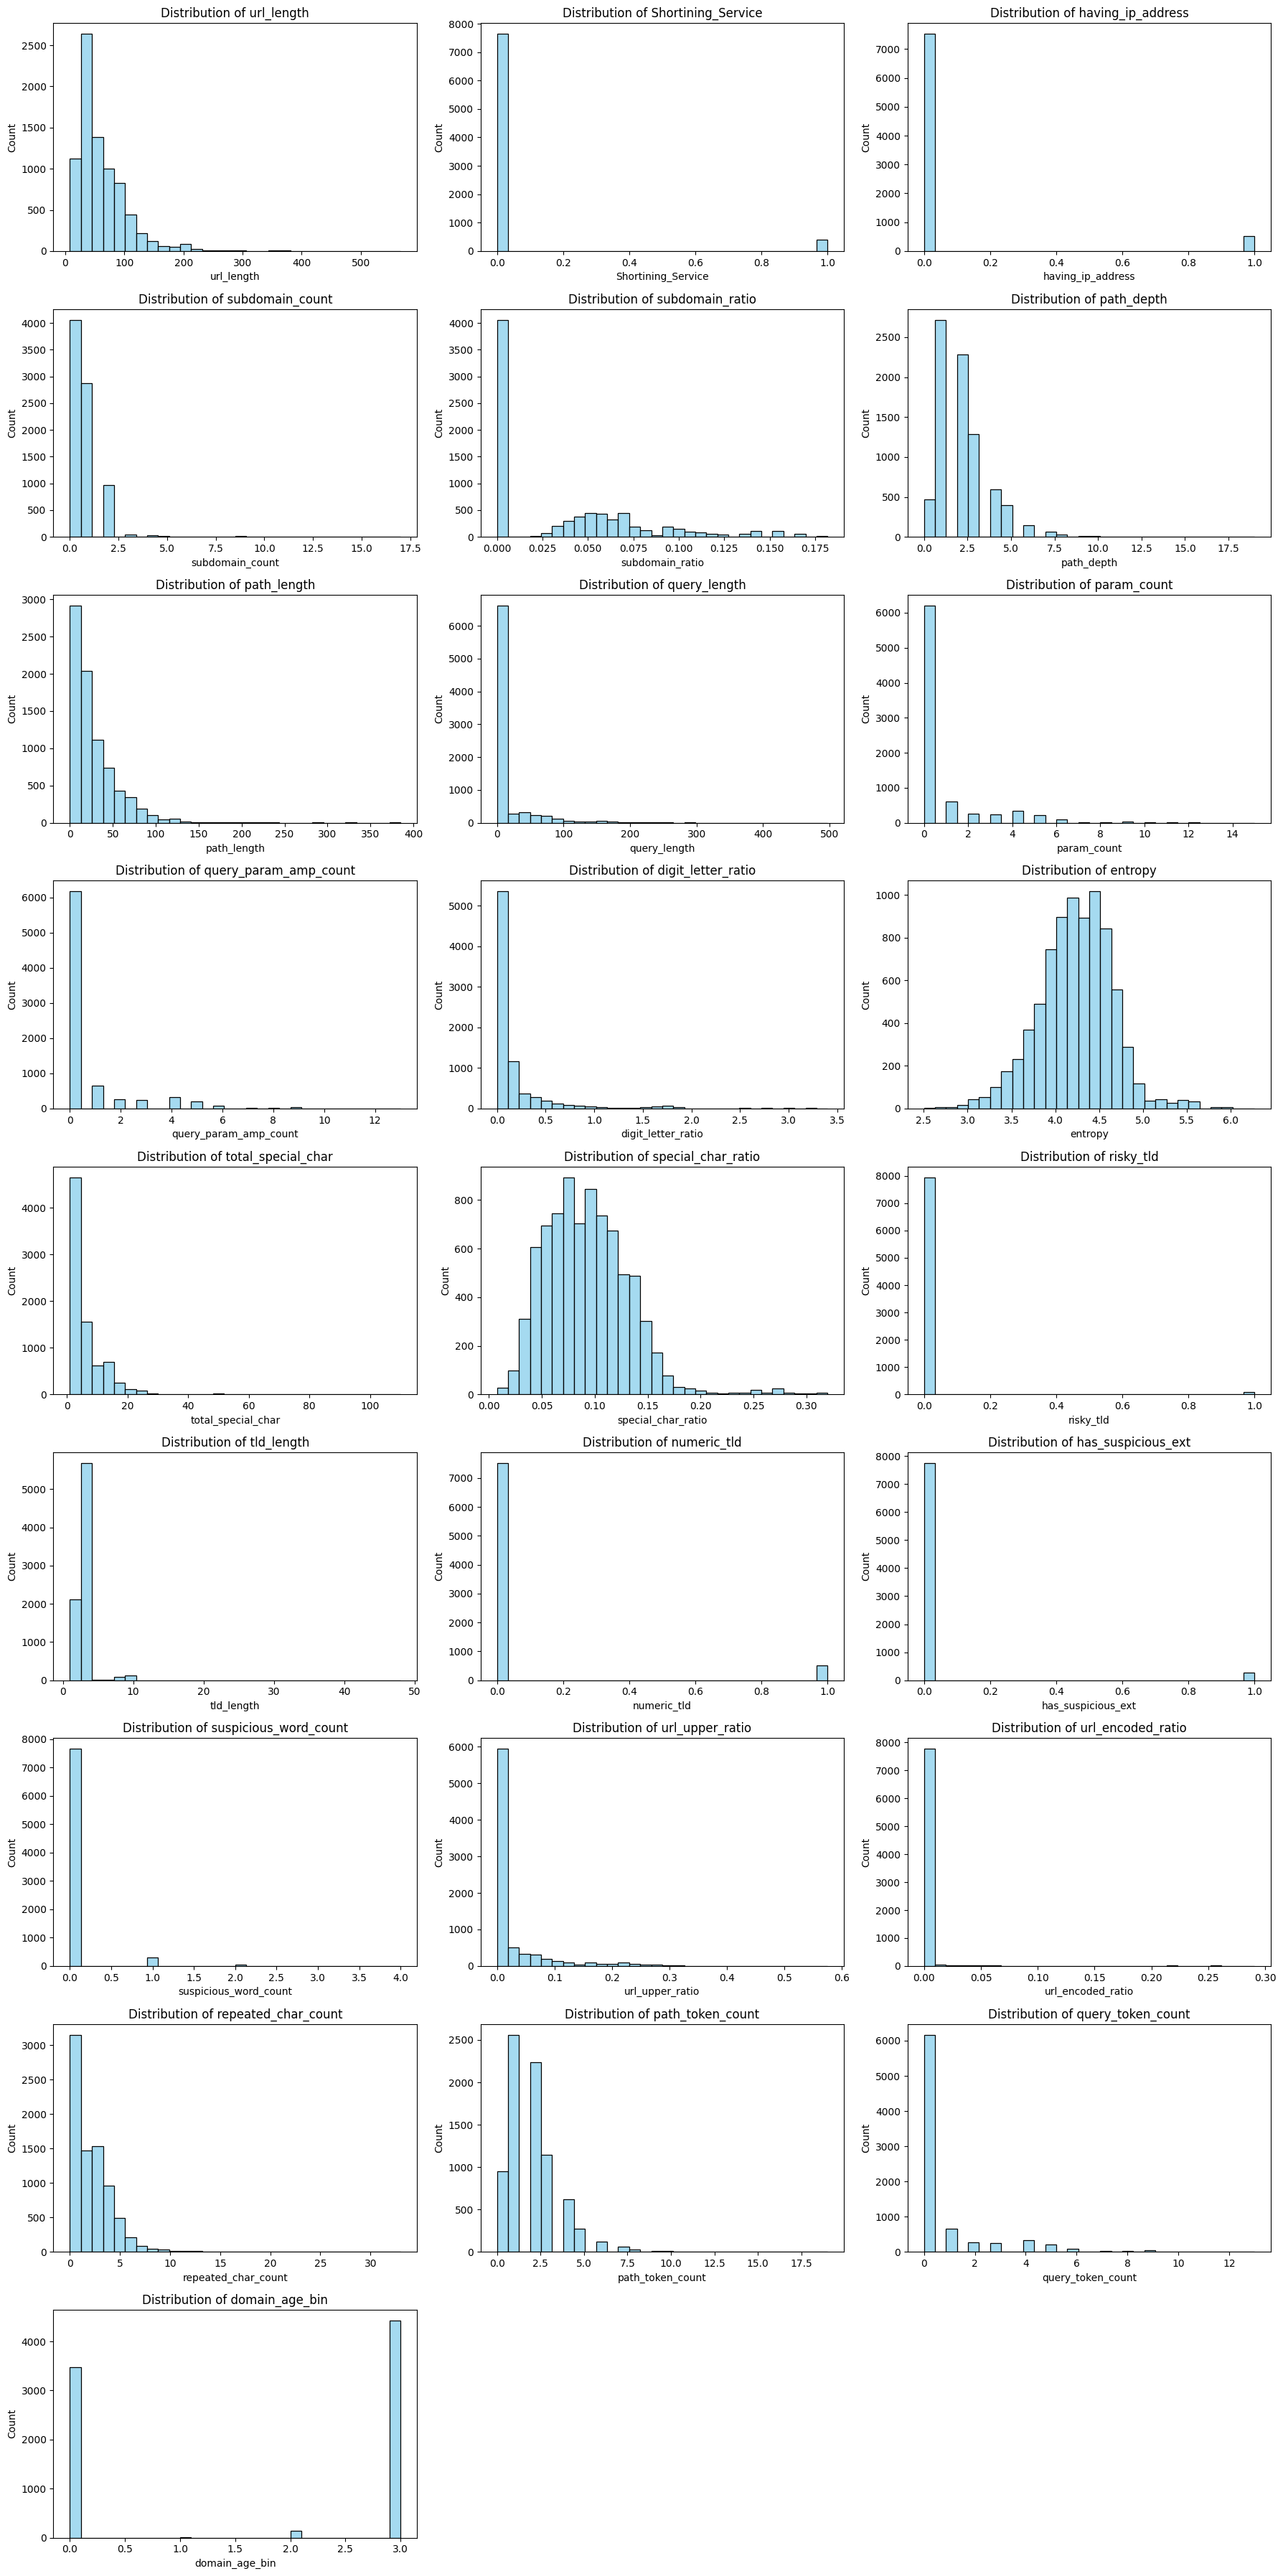

C:\Users\super\AppData\Local\Temp\ipykernel_20344\1914516361.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=features_df, palette='Set2')


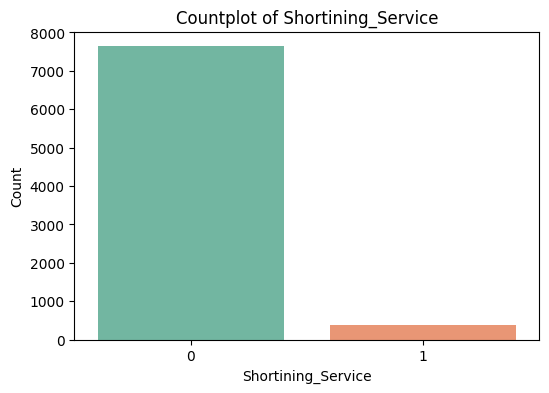

C:\Users\super\AppData\Local\Temp\ipykernel_20344\1914516361.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=features_df, palette='Set2')


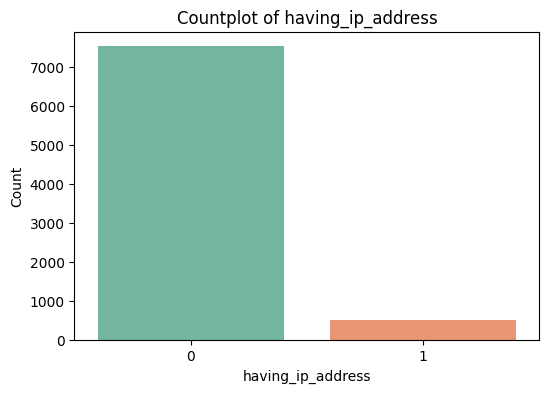

C:\Users\super\AppData\Local\Temp\ipykernel_20344\1914516361.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=features_df, palette='Set2')


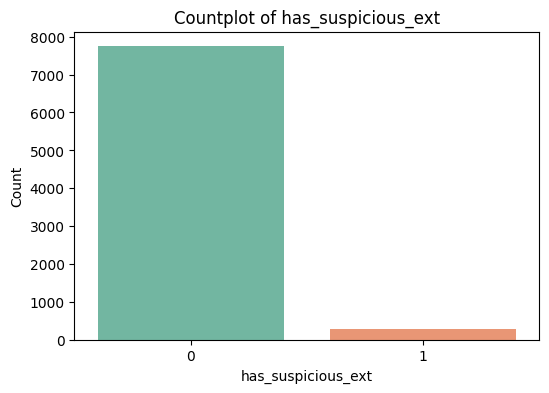

C:\Users\super\AppData\Local\Temp\ipykernel_20344\1914516361.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=features_df, palette='Set2')


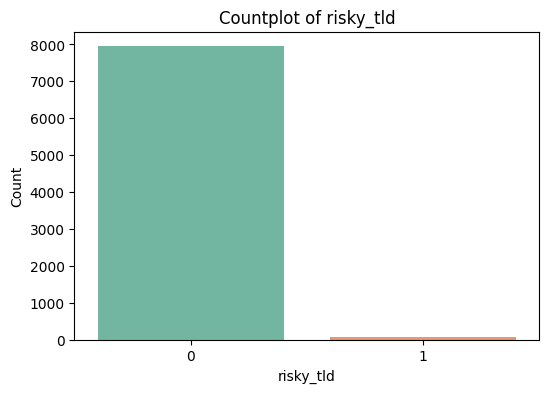

C:\Users\super\AppData\Local\Temp\ipykernel_20344\1914516361.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=features_df, palette='Set2')


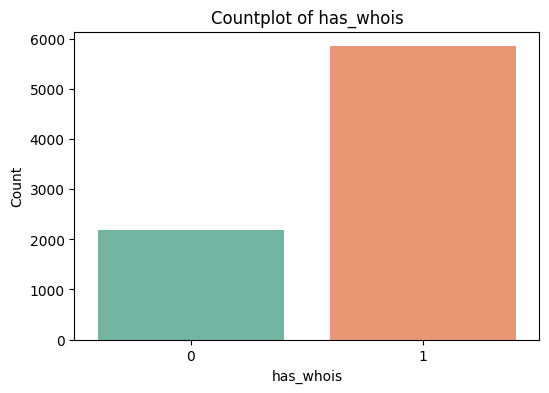

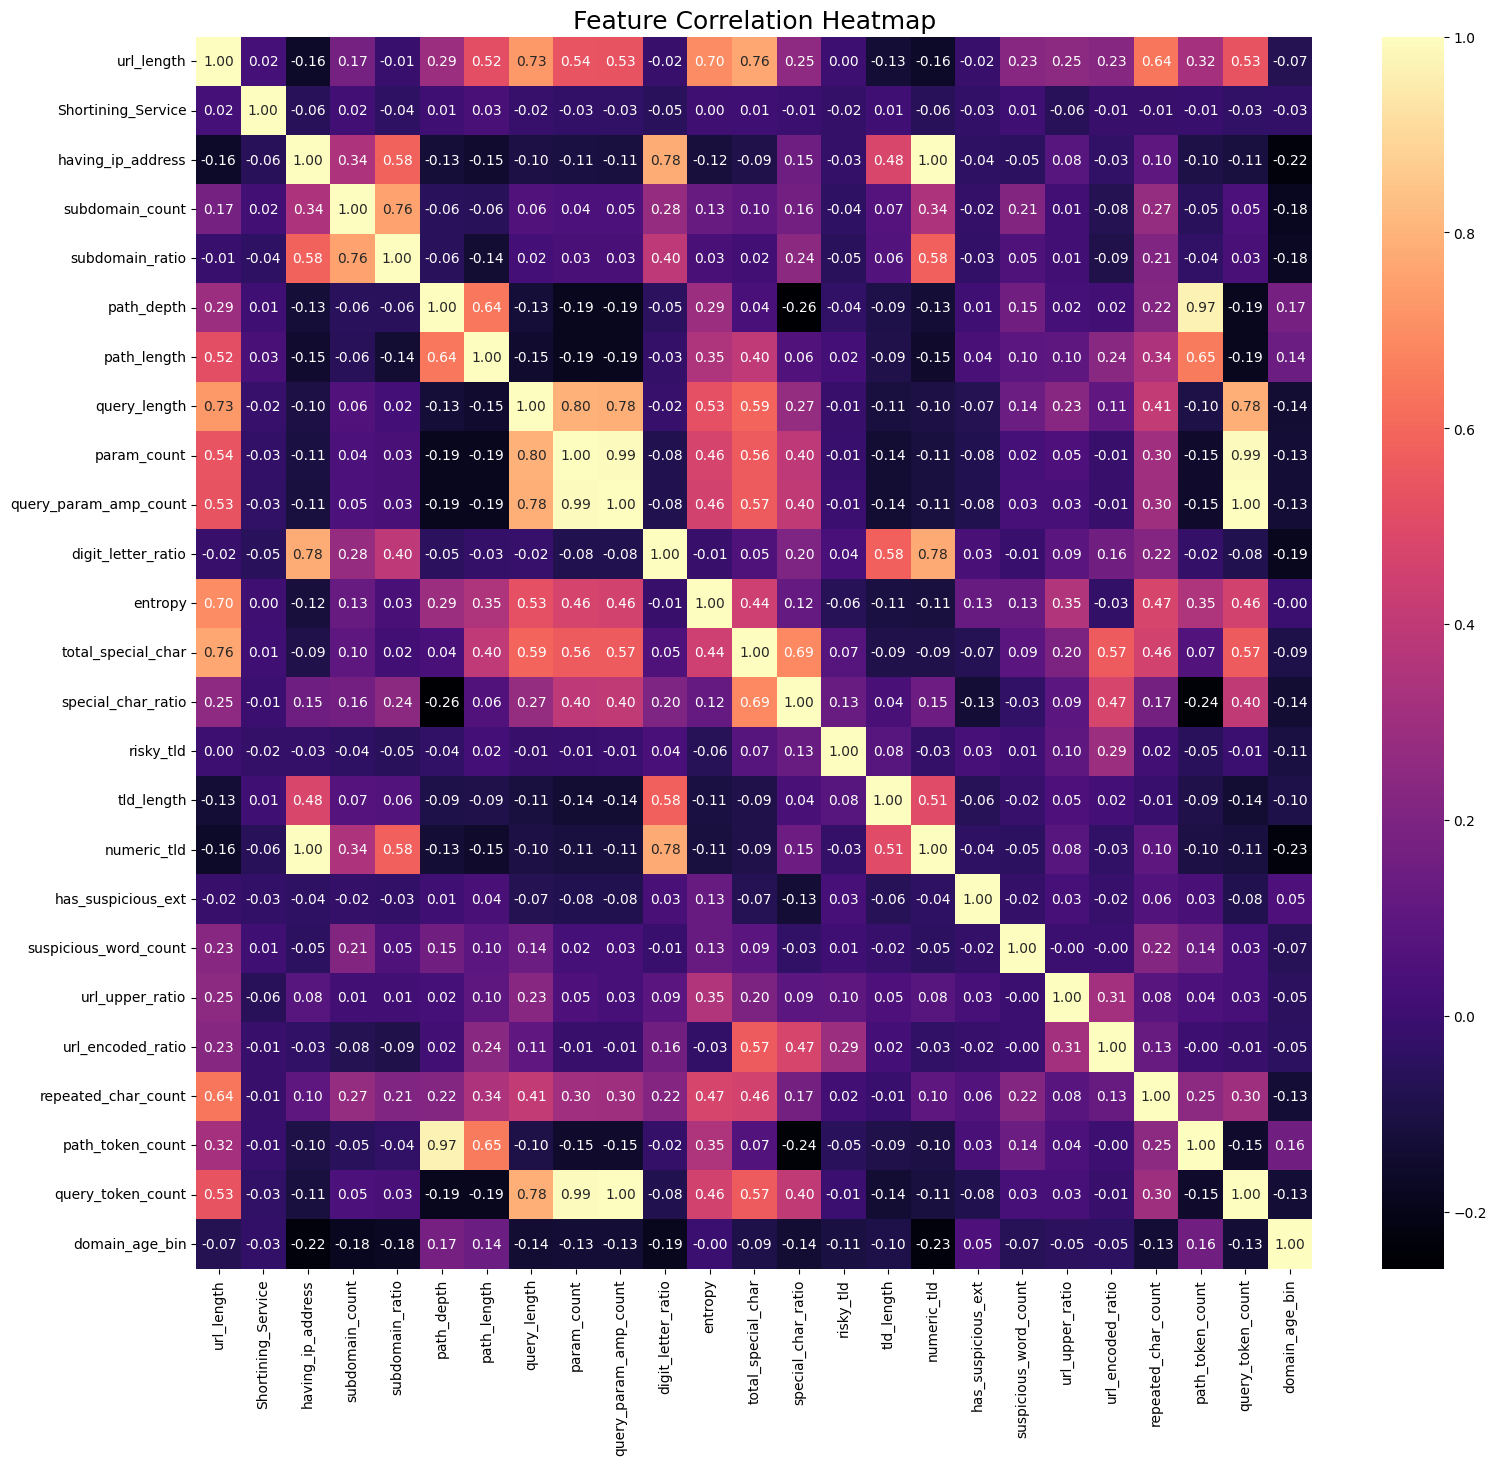

In [10]:
# ===============================
# Step 5: Exploratory Data Analysis (Numeric Features Fixed)
# ===============================

import matplotlib.pyplot as plt
import seaborn as sns
import math

# -------------------------------
# 1️⃣ Numeric features for histograms (fixed layout)
# -------------------------------
numeric_features = features_df.select_dtypes(include=['float64', 'int64'])
numeric_features = numeric_features.drop(columns=['has_whois','domain_age_days'], errors='ignore')

num_cols = len(numeric_features.columns)
num_rows = math.ceil(num_cols / 3)  # 3 columns per row

fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows*4))
axes = axes.flatten()

for i, col in enumerate(numeric_features.columns):
    sns.histplot(numeric_features[col], bins=30, kde=False, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# -------------------------------
# 2️⃣ Binary/Categorical features plots
# -------------------------------
binary_features = [
    "Shortining_Service",
    "having_ip_address",
    "suspicious_words",
    "has_suspicious_ext",
    "risky_tld",
    "has_whois"
]
binary_features_existing = [col for col in binary_features if col in features_df.columns]

for col in binary_features_existing:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=features_df, palette='Set2')
    plt.title(f"Countplot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# -------------------------------
# 3️⃣ Correlation Heatmap
# -------------------------------
plt.figure(figsize=(18,16))
sns.heatmap(numeric_features.corr(), annot=True, fmt=".2f", cmap="magma", cbar=True)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.show()



### Training & Evaluating: Random Forest
Accuracy: 91.72%
              precision    recall  f1-score   support

   malicious       0.91      0.93      0.92       803
        safe       0.93      0.91      0.92       803

    accuracy                           0.92      1606
   macro avg       0.92      0.92      0.92      1606
weighted avg       0.92      0.92      0.92      1606



<Figure size 800x600 with 0 Axes>

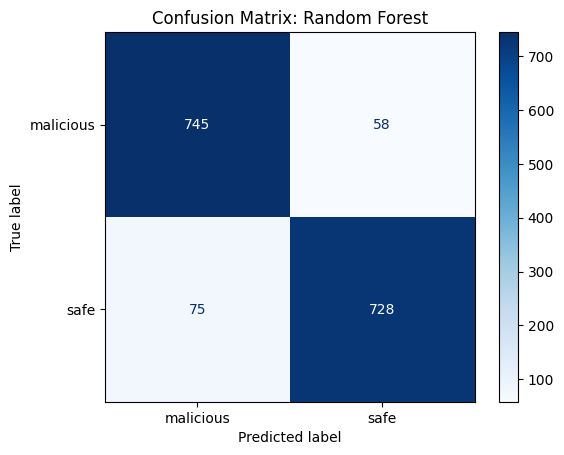

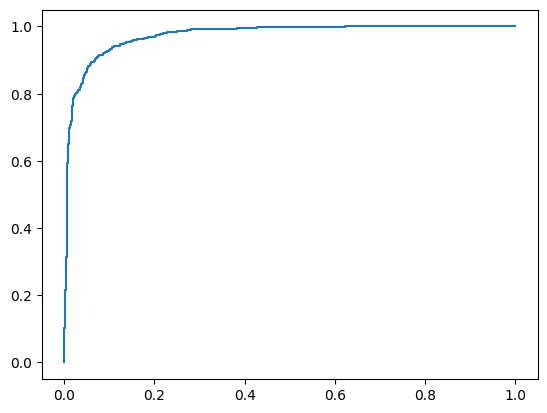

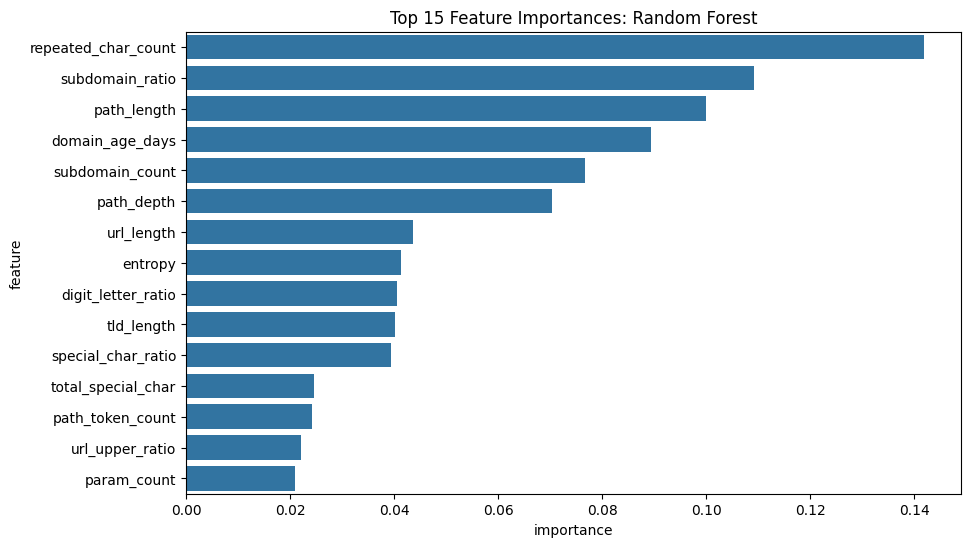


### Training & Evaluating: XGBoost


d:\QRusaderTrainedModel\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 92.59%
              precision    recall  f1-score   support

   malicious       0.92      0.93      0.93       803
        safe       0.93      0.92      0.93       803

    accuracy                           0.93      1606
   macro avg       0.93      0.93      0.93      1606
weighted avg       0.93      0.93      0.93      1606



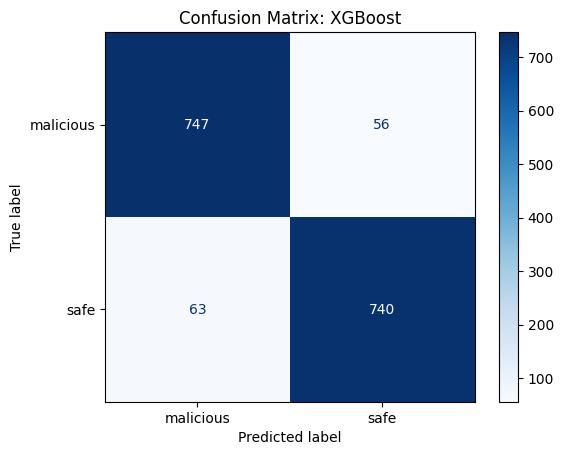

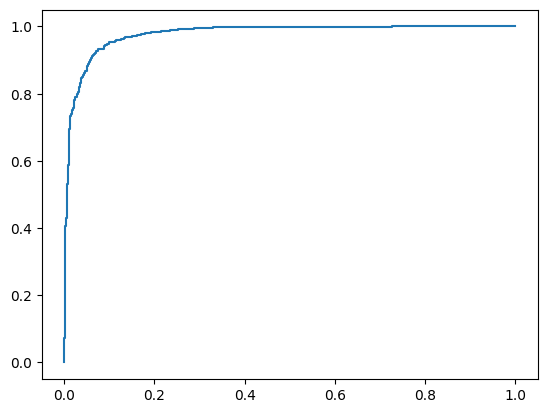

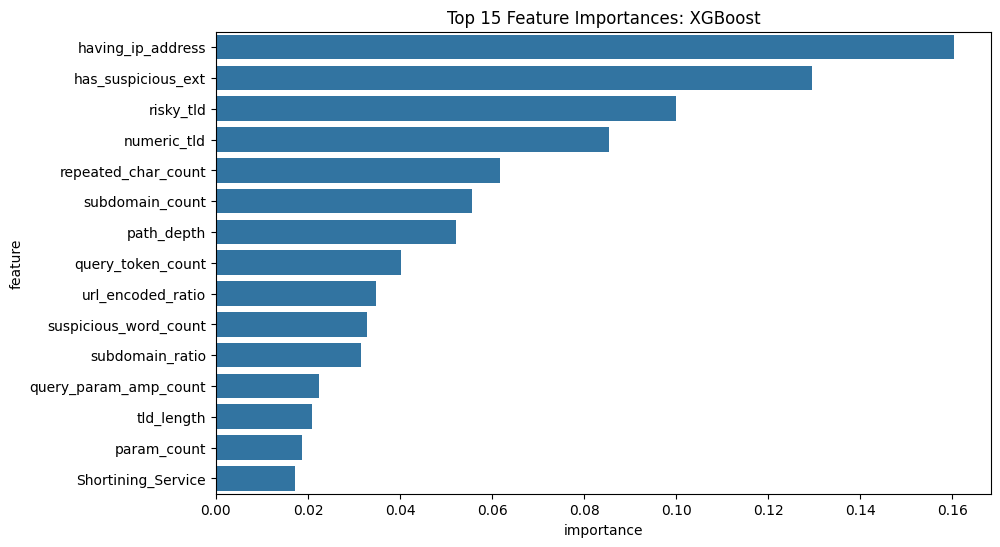


### Training & Evaluating: Stacking (XGB Meta)


d:\QRusaderTrainedModel\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\QRusaderTrainedModel\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\QRusaderTrainedModel\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\QRusaderTrainedModel\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

Accuracy: 92.78%
              precision    recall  f1-score   support

   malicious       0.92      0.93      0.93       803
        safe       0.93      0.92      0.93       803

    accuracy                           0.93      1606
   macro avg       0.93      0.93      0.93      1606
weighted avg       0.93      0.93      0.93      1606



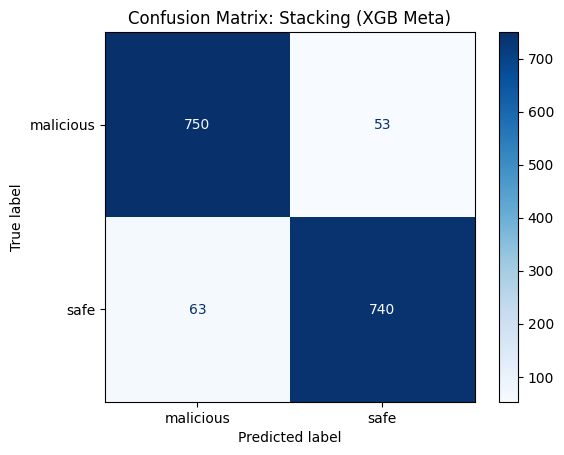

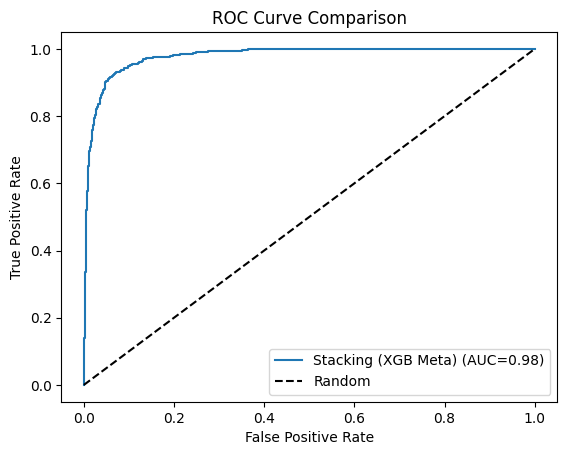

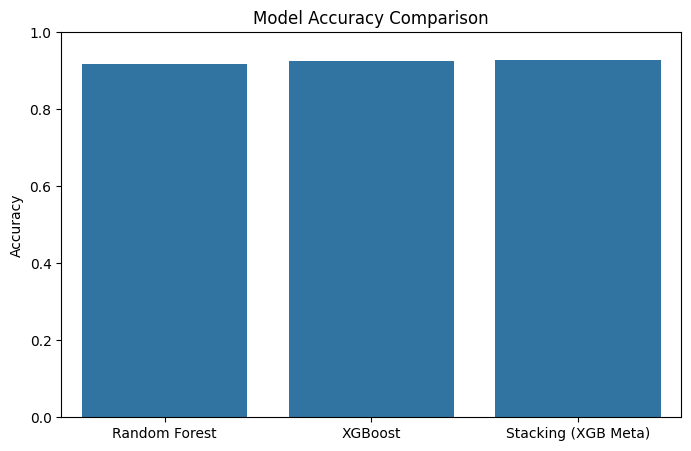

In [11]:
# ===============================
# Optimized Training & Evaluation: RF, XGBoost, Stacking (XGB Meta)
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

# -------------------------------
# 1️⃣ Prepare features and labels
# -------------------------------
X = features_df.select_dtypes(include=['float64','int64']).fillna(0)
y = features_df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -------------------------------
# 2️⃣ Base models
# -------------------------------
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=2, random_state=42)
xgb = XGBClassifier(
    n_estimators=1000, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric='logloss', use_label_encoder=False, random_state=42
)

# -------------------------------
# 3️⃣ Stacking Ensemble (XGB meta-learner)
# -------------------------------
stacking_xgb = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=XGBClassifier(
        n_estimators=300, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', use_label_encoder=False, random_state=42
    ),
    cv=5,
    passthrough=True
)

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "Stacking (XGB Meta)": stacking_xgb
}

# -------------------------------
# 4️⃣ Train & Evaluate
# -------------------------------
accuracies = {}
plt.figure(figsize=(8,6))
y_test_bin = LabelBinarizer().fit_transform(y_test)  # for ROC

for name, model in models.items():
    print("\n" + "="*50)
    print(f"### Training & Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Accuracy: {acc*100:.2f}%")
    
    # Classification report
    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_pred)
    print(classification_report(y_test_labels, y_pred_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        if len(y_score.shape) == 1:
            y_score = y_score.reshape(-1,1)
    
    fpr, tpr, _ = roc_curve(y_test_bin, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    
    # Top 15 Feature Importances
    if hasattr(model, "feature_importances_"):
        feat_imp_df = pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        }).sort_values(by="importance", ascending=False)
        
        plt.figure(figsize=(10,6))
        sns.barplot(x="importance", y="feature", data=feat_imp_df.head(15))
        plt.title(f"Top 15 Feature Importances: {name}")
        plt.show()

# -------------------------------
# 5️⃣ Plot ROC curves comparison
# -------------------------------
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# -------------------------------
# 6️⃣ Accuracy Comparison
# -------------------------------
plt.figure(figsize=(8,5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


In [12]:
print(le.classes_)

['malicious' 'safe']


In [13]:
print(features_df.columns)

Index(['url', 'domain', 'url_length', 'Shortining_Service',
       'having_ip_address', 'subdomain_count', 'subdomain_ratio', 'path_depth',
       'path_length', 'query_length', 'param_count', 'query_param_amp_count',
       'digit_letter_ratio', 'entropy', 'total_special_char',
       'special_char_ratio', 'risky_tld', 'tld_length', 'numeric_tld',
       'has_suspicious_ext', 'suspicious_word_count', 'url_upper_ratio',
       'url_encoded_ratio', 'repeated_char_count', 'path_token_count',
       'query_token_count', 'has_whois', 'domain_age_days', 'domain_age_bin',
       'label'],
      dtype='object')


In [15]:
import joblib

# Save stacking model
joblib.dump(stacking_xgb, r"D:\QRusaderTrainedModel\models\stacking_model.pkl")
print("✅ Stacking model saved successfully!")

# Save label encoder
joblib.dump(le, r"D:\QRusaderTrainedModel\models\label_encoder.pkl")
print("✅ Label encoder saved successfully!")

# Save feature columns
joblib.dump(list(X.columns), r"D:\QRusaderTrainedModel\models\feature_columns.pkl")
print("✅ Feature columns saved successfully!")

✅ Stacking model saved successfully!
✅ Label encoder saved successfully!
✅ Feature columns saved successfully!


In [16]:
import pandas as pd
import joblib

# -------------------------------
# 1️⃣ Load saved objects
# -------------------------------
stacking_model = joblib.load(r"D:\QRusaderTrainedModel\models\stacking_model.pkl")
le = joblib.load(r"D:\QRusaderTrainedModel\models\label_encoder.pkl")
feature_columns = joblib.load(r"D:\QRusaderTrainedModel\models\feature_columns.pkl")

# Make sure extract_features function is imported from your features.py
# from features import extract_features

# -------------------------------
# 2️⃣ Pick 10 random URLs from your dataset
# -------------------------------
sample_df = features_df.sample(n=20, random_state=42)  # your original dataset
print("🔎 Testing on 20 random URLs:\n")

y_true = []
y_pred = []

for idx, row in sample_df.iterrows():
    url = row["url"]         # adjust to your dataset column name
    true_label = row["label"]
    
    # ✅ Extract features from URL
    feats = extract_features(url)
    
    # Align with training feature order
    feats_df = pd.DataFrame([feats])
    for col in feature_columns:
        if col not in feats_df.columns:
            feats_df[col] = 0  # fill missing features
    feats_df = feats_df[feature_columns].fillna(0)
    
    # 🔑 Predict
    pred_encoded = stacking_model.predict(feats_df)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]
    
    # Save true label (only if it exists in LabelEncoder classes)
    if true_label in le.classes_:
        true_label_decoded = true_label
    else:
        true_label_decoded = "unknown"

    y_true.append(true_label_decoded)
    y_pred.append(pred_label)

    print(f"URL: {url}")
    print(f"   True Label: {true_label_decoded} | Predicted Label: {pred_label}\n")

# -------------------------------
# 3️⃣ Accuracy on 10 samples
# -------------------------------
correct = sum(1 for t, p in zip(y_true, y_pred) if t == p and t != "unknown")
total_known = sum(1 for t in y_true if t != "unknown")
if total_known > 0:
    print(f"✅ Accuracy on 10 samples (excluding unknowns): {correct}/{total_known} = {correct/total_known*100:.1f}%")
else:
    print("⚠️ No known labels to calculate accuracy.")


🔎 Testing on 20 random URLs:

URL: http://www.evasteinberger.at/de/berichte/38-berichte-2012/93-banesto-tour-212.html?tmpl=component&print=1&layout=default&page=
   True Label: malicious | Predicted Label: malicious

URL: http://www.alviksby.se/index.php?option=com_weblinks&view=categories&Itemid=40
   True Label: malicious | Predicted Label: malicious

URL: us.linkedin.com/pub/dir/Charles+(Chuck)/Fletcher
   True Label: safe | Predicted Label: safe

URL: http://kensonsitepcrepair.com/a/secure/
   True Label: malicious | Predicted Label: malicious



C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)
C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)


URL: http://www.tirionklasse.nl/foto/item/208/asInline.html
   True Label: malicious | Predicted Label: malicious

URL: https://pastebin.com/raw/PDr6aV1b
   True Label: malicious | Predicted Label: malicious

URL: stormarashiyaniee.blogspot.com/2011/02/arashi-concert-5x10-english-romaji-sub.html
   True Label: safe | Predicted Label: safe

URL: www.northbelconnenbaptist.org.au/rp/index.php
   True Label: safe | Predicted Label: safe



C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)
C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)


URL: www.woodheadpublishing.com/en/book.aspx?bookID=505
   True Label: malicious | Predicted Label: malicious

URL: trulia.com/schools/NJ-Newark/Lincoln_Elementary_School/
   True Label: safe | Predicted Label: safe

URL: artknowledgenews.com/2010-02-08-00-01-23-musee-dart-contemporain-de-montreal-hosts-survey-of-marcel-dzamas-outrageous-art.html
   True Label: safe | Predicted Label: safe

URL: http://norwestcooling.com/clients.html
   True Label: malicious | Predicted Label: malicious

URL: youtube.com/watch?v=G-4Rss2j9O0
   True Label: safe | Predicted Label: safe

URL: facebook.com/people/Deborah-Adey/551657471
   True Label: safe | Predicted Label: safe



C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)
C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)
C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

URL: myetherwalletru.info
   True Label: malicious | Predicted Label: malicious

URL: chinatouristmaps.com/travel/fujian.html
   True Label: safe | Predicted Label: safe

URL: charlesjosephsalons.com/
   True Label: safe | Predicted Label: safe

URL: http://www.radiovillage.eu/index.php/rvcommunity/105-paolo/profile.html
   True Label: malicious | Predicted Label: malicious



C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)
C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = feats_df[feature_columns].fillna(0)
C:\Users\super\AppData\Local\Temp\ipykernel_20344\1198128398.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

URL: http://asload01.top/download.php?file=5.exe
   True Label: malicious | Predicted Label: malicious

URL: campbellriverproperty.com/
   True Label: safe | Predicted Label: safe

✅ Accuracy on 10 samples (excluding unknowns): 20/20 = 100.0%


In [17]:
import pandas as pd

# List to store results
results = []

for idx, row in features_df.iterrows():
    url = row["url"]
    true_label = row["label"]

    # Extract features
    feats = extract_features(url)
    feats_df = pd.DataFrame([feats])[feature_columns].fillna(0).infer_objects()

    # Predict
    pred_encoded = stacking_model.predict(feats_df)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]

    # Get probability of 'malicious' (assuming label order is ['safe','malicious'])
    prob_malicious = stacking_model.predict_proba(feats_df)[0][le.transform(['malicious'])[0]]

    results.append({
        "URL": url,
        "True Label": true_label,
        "Predicted Label": pred_label,
        "Malicious Probability": prob_malicious
    })

# Convert to DataFrame and save
predict_df = pd.DataFrame(results)
predict_df.to_csv("predict_batch.csv", index=False)
print("✅ Predictions saved to predict_batch.csv")
# -------------------------------
# Storing URLs results with predictions
# -------------------------------

C:\Users\super\AppData\Local\Temp\ipykernel_20344\3584193696.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = pd.DataFrame([feats])[feature_columns].fillna(0).infer_objects()
C:\Users\super\AppData\Local\Temp\ipykernel_20344\3584193696.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats_df = pd.DataFrame([feats])[feature_columns].fillna(0).infer_objects()
C:\Users\super\AppData\Local\Temp\ipykernel_20344\3584193696.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fut

✅ Predictions saved to predict_batch.csv


In [18]:
import pandas as pd

# Load the CSV
predict_df = pd.read_csv("predict_batch.csv")

# Preview the first 10 rows
predict_df.head(10)

# Optional: show summary statistics of the probabilities
predict_df["Malicious Probability"].describe()

# Optional: see how many predicted as malicious vs safe
predict_df["Predicted Label"].value_counts()


Predicted Label
malicious    4024
safe         4004
Name: count, dtype: int64

In [19]:
import pandas as pd

# Load predictions
predict_df = pd.read_csv("predict_batch.csv")

# Optionally, add a "Malicious Probability (%)" column
predict_df["Malicious Probability (%)"] = predict_df["Malicious Probability"] * 100

# Display the first 10 rows as a table
predict_df.head(10)


,URL,True Label,Predicted Label,Malicious Probability,Malicious Probability (%)
0,myspace.com/denigauthier,safe,safe,0.002272,0.227195
1,http://censor.net.ua/news/336002/spetsstatus_d...,safe,safe,0.120429,12.042922
2,http://144.202.124.211/d/xd.ppc,malicious,malicious,0.998794,99.879444
3,http://1.34.247.36:35473/.i,malicious,malicious,0.998270,99.826956
4,www.australianwebservices.com/attachments/payp...,safe,safe,0.025776,2.577639
5,http://kizombafestival.pl/index.php?option=com...,malicious,malicious,0.998656,99.865590
6,obit-obits.com/d20091114zp21,safe,safe,0.034509,3.450942
7,theegarbageheap.blogspot.com/,safe,safe,0.001570,0.157040
8,stjohns.edu/academics/undergraduate/liberalart...,safe,safe,0.018495,1.849526
9,pep-web.org/document.php?id=cps.023.0604a,safe,safe,0.000896,0.089580


In [23]:
# ===============================
# Predict using saved Stacking Model
# ===============================

import pandas as pd
import joblib

# -------------------------------
# 1️⃣ Load saved objects
# -------------------------------
stacking_model = joblib.load(r"D:\QRusaderTrainedModel\models\stacking_model.pkl")
le = joblib.load(r"D:\QRusaderTrainedModel\models\label_encoder.pkl")
feature_columns = joblib.load(r"D:\QRusaderTrainedModel\models\feature_columns.pkl")

# -------------------------------
# 2️⃣ Define the extract_features function
# -------------------------------
import re, math
from urllib.parse import urlparse
from datetime import datetime

def shannon_entropy(data):
    if not data:
        return 0
    prob = [float(data.count(c))/len(data) for c in set(data)]
    return -sum(p*math.log2(p) for p in prob)

suspicious_keywords = ["secure","account","login","update","free","bonus",
                       "ebayisapi","banking","confirm","signin","verification"]

def contains_suspicious_word(url):
    return sum(word in url.lower() for word in suspicious_keywords)

def has_ip(url):
    return 1 if re.match(r"http[s]?://\d+\.\d+\.\d+\.\d+", url) else 0

def is_shortened(url):
    shortening_services = ["bit.ly","tinyurl","goo.gl","t.co","ow.ly","shorte.st","cutt.ly"]
    return 1 if any(s in url for s in shortening_services) else 0

def has_suspicious_ext(url):
    suspicious_ext = [
    ".exe", ".bat", ".cmd", ".msi", ".scr",
    ".js", ".vbs", ".wsf", ".ps1", ".jar", ".hta",
    ".docm", ".xlsm", ".pptm", ".zip", ".rar", ".7z",
    ".tar", ".gz", ".apk", ".pif", ".lnk", ".iso", ".img"
    ]
    return 1 if any(url.lower().endswith(ext) for ext in suspicious_ext) else 0

def extract_features(url):
    parsed = urlparse(url if url.startswith("http") else "http://" + url)
    domain = parsed.netloc or parsed.path
    path = parsed.path
    query = parsed.query

    total_special_char = sum(url.count(c) for c in ['@','?','-','=','.','!','#','$','&','~','*','%','+','^','_'])
    special_char_ratio = total_special_char / max(1, len(url))
    subdomain_count = max(domain.count(".") - 1, 0)
    path_depth = path.count('/')
    query_param_amp_count = query.count('&') + (1 if query else 0)
    tld = domain.split('.')[-1]
    tld_length = len(tld)
    numeric_tld = 1 if any(c.isdigit() for c in tld) else 0
    subdomain_ratio = subdomain_count / max(1, len(domain))
    digit_letter_ratio = sum(c.isdigit() for c in url) / max(1, sum(c.isalpha() for c in url))
    url_upper_ratio = sum(1 for c in url if c.isupper()) / max(1, len(url))
    url_encoded_ratio = url.count('%') / max(1, len(url))
    repeated_char_count = sum(url.count(c*2) for c in set(url))
    path_token_count = len([t for t in path.split('/') if t])
    query_token_count = len([q for q in query.split('&') if q])
    suspicious_word_count = contains_suspicious_word(url)

    # For whois info, just approximate as available in training
    has_whois = 1
    domain_age_days = 1000
    domain_age_bin = 3

    return {
        "url": url,
        "domain": domain,
        "url_length": len(url),
        "Shortining_Service": is_shortened(url),
        "having_ip_address": has_ip(url),
        "subdomain_count": subdomain_count,
        "subdomain_ratio": subdomain_ratio,
        "path_depth": path_depth,
        "path_length": len(path),
        "query_length": len(query),
        "param_count": query.count("="),
        "query_param_amp_count": query_param_amp_count,
        "digit_letter_ratio": digit_letter_ratio,
        "entropy": shannon_entropy(url),
        "total_special_char": total_special_char,
        "special_char_ratio": special_char_ratio,
        "risky_tld": 1 if tld in ["zip","xyz","top","club","info"] else 0,
        "tld_length": tld_length,
        "numeric_tld": numeric_tld,
        "has_suspicious_ext": has_suspicious_ext(url),
        "suspicious_word_count": suspicious_word_count,
        "url_upper_ratio": url_upper_ratio,
        "url_encoded_ratio": url_encoded_ratio,
        "repeated_char_count": repeated_char_count,
        "path_token_count": path_token_count,
        "query_token_count": query_token_count,
        "has_whois": has_whois,
        "domain_age_days": domain_age_days,
        "domain_age_bin": domain_age_bin
    }

# -------------------------------
# 3️⃣ Example prediction
# -------------------------------
test_url = "https://github.com/DreigAguila/QRusaderTrainedModel.git"
feats = extract_features(test_url)
feats_df = pd.DataFrame([feats])[feature_columns].fillna(0)

pred_encoded = stacking_model.predict(feats_df)[0]
pred_label = le.inverse_transform([pred_encoded])[0]
prob_malicious = stacking_model.predict_proba(feats_df)[0][le.transform(['malicious'])[0]]

print(f"\n🔗 URL: {test_url}")
print(f"Predicted Label: {pred_label}")
print(f"Malicious Probability: {prob_malicious*100:.2f}%")



🔗 URL: https://github.com/DreigAguila/QRusaderTrainedModel.git
Predicted Label: safe
Malicious Probability: 39.14%
